# Pan-Tompkins QRS Detection Algorithm Using ZYNQ Z-7007s Hardware

### Toronto Metropolitan Capstone 2024/2025 Group Code: GK01
### Authors
1. Timmy Huy Xuan Ngo
2. Henry Arboladora
3. Fairuj Tabassum
4. Christian Sorto

### Project Summary
Project defines analysis of QRS complex of pre-existing data of human heart activity. Application is partitioned with AMD's Zynq Z-7007s single-core SoC where it was deployed on the Cora Z7-07s development board.

## Imports

In [3]:
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os, warnings

print("done")

done


## Data Set

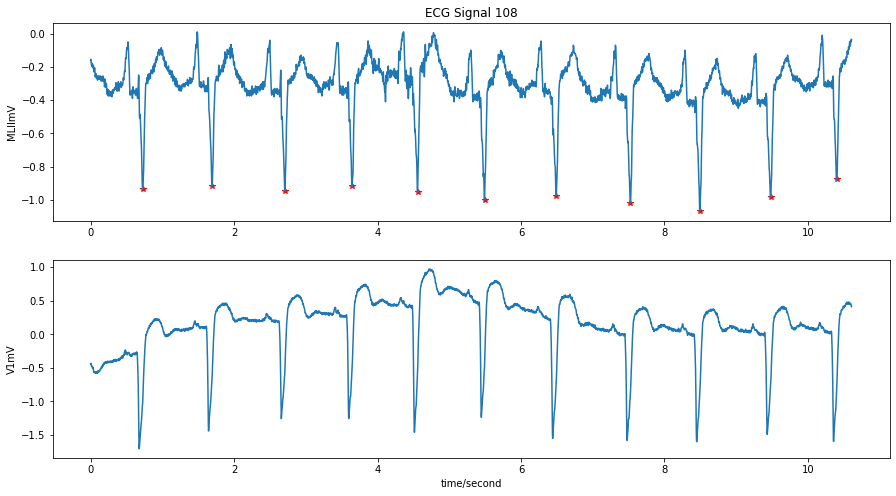

In [4]:
# Specify the record number
record_number = 108

# Load the ECG signal and annotations
filename = f'mit-bih-arrhythmia-database-1.0.0/{record_number}'
record = wfdb.rdrecord(filename, sampfrom=180, sampto=4000,)    
annotation = wfdb.rdann(filename, 'atr', sampfrom=180, sampto=4000, shift_samps=True)

# Plot the ECG signal with annotations
wfdb.plot_wfdb(record=record, annotation=annotation, title=f"ECG Signal {record_number}", time_units='seconds', figsize=(15, 8))

## Checking Hardware Resources and Clocks

In [5]:
from pynq import Clocks
from pynq import MMIO
import psutil
import subprocess

# Total RAM on the SoC
ram_memory = subprocess.Popen("free -m | awk '/Mem:/ {print $2}'", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
output, error = ram_memory.communicate()

if ram_memory.returncode == 0:
    print(f"Total SoC Memory: {output.decode().strip()} MB")
else:
    print("Error retrieving memory:", error.decode().strip())

# Total Available Memory for PL
try:
    mmio = MMIO(0x40000000, 4)
    print("PL memory accessed")
except Exception as e:
    print("PL memory is not accessed: {e}")
    
# Total Contiguous Memory Allocator (CMA) Memory
output = os.popen("cat /proc/meminfo | grep CmaTotal").read().strip()

if output:
    cma_memory_KB = int(output.split()[1])
    cma_memory_MB = cma_memory_KB / 1024
    print(f"Total CMA Memory: {cma_memory_MB:.2f} MB")
else:
    print("Error displaying CMA memory!")

# Alternate Way To Show Total RAM on the SoC
ram_memory2 = psutil.virtual_memory()
print(f"Total SoC Memory: {ram_memory2.total / (1024 * 1024)} MB")
print(f"Total Available SoC Memory: {ram_memory2.available / (1024 * 1024)} MB")

# Showing Clocks
print("Printing Clocks...")
print(f'CPU: {Clocks.cpu_mhz:.6f}MHz')
print(f'FCLK0: {Clocks.fclk0_mhz:.6f}MHz')
print(f'FCLK1: {Clocks.fclk1_mhz:.6f}MHz')
print(f'FCLK2: {Clocks.fclk2_mhz:.6f}MHz')
print(f'FCLK3: {Clocks.fclk3_mhz:.6f}MHz')

Total SoC Memory: 496 MB
PL memory accessed
Total CMA Memory: 128.00 MB
Total SoC Memory: 496.6953125 MB
Total Available SoC Memory: 320.23046875 MB
Printing Clocks...
CPU: 650.000000MHz
FCLK0: 50.000000MHz
FCLK1: 41.666667MHz
FCLK2: 41.666667MHz
FCLK3: 41.666667MHz


## Pan-Tompkins Algorithm

In [6]:
from pynq import Overlay
from pynq import PL
from pynq import Xlnk
from scipy.signal import savgol_filter

# PS Clock Control
if not os.path.exists(PL.bitfile_name):
    warnings.warn('There is no overlay loaded after boot.', UserWarning)

overlay = Overlay("overlays/fir_accel.bit")

dma = overlay.filter.fir_dma

class Pan_Tompkins_QRS():
    def __init__(self, dma):
        self.dma = dma  # DMA object to handle transfers

    def hw_acceleration(self, signal):
        '''
        This method uses DMA to send and receive data for the bandpass and derivative filters.
        It sends the signal to FPGA for processing and receives the processed result.
        '''
        n = len(signal)  # Length of the input signal

        # Initialize Xlnk for memory allocation
        xlnk = Xlnk()
        in_buffer = xlnk.cma_array(shape=(n,), dtype=np.int32)  # Input buffer for DMA transfer
        out_buffer = xlnk.cma_array(shape=(n,), dtype=np.int32)  # Output buffer for DMA receive

        # Copy the input signal into the buffer
        np.copyto(in_buffer, signal)

        # Trigger the DMA transfer (sending data to FPGA)
        print("Starting DMA transfer...")
        self.dma.sendchannel.transfer(in_buffer)

        # Trigger the DMA receive (receiving data back from FPGA after processing)
        self.dma.recvchannel.transfer(out_buffer)

        # Start the DMA transfer and wait for it to complete
        start_time = time.time()
        print("Waiting for DMA to complete...")

        # Wait for both send and receive transfers to complete
        self.dma.sendchannel.wait()
        self.dma.recvchannel.wait()

        print("DMA transfer completed.")
        print("Time taken for DMA transfer:", time.time() - start_time)

        # Return the processed result from FPGA
        return out_buffer
    
    def apply_savgol_filter(self, signal, window_length, polyorder, deriv=1):
        '''
        Smooth the signal using the Savitzky-Golay filter.
        Parameters:
        signal: The input signal (1D array)
        window_length: Length of the filter window (must be odd)
        polyorder: Polynomial order (integer, less than window_length)
        Returns:
        Smoothed signal
        '''
        return savgol_filter(signal, window_length, polyorder)
    
    def derivative(self,signal):
        '''
        Derivative Filter 
        :param signal: input signal
        :return: prcoessed signal

        Methodology/Explaination:
        The derivative of the input signal is taken to obtain the
        information of the slope of the signal. Thus, the rate of change
        of input is obtain in this step of the algorithm.

        The derivative filter has the recursive equation:
          y(nT) = [-x(nT - 2T) - 2x(nT - T) + 2x(nT + T) + x(nT + 2T)]/(8T)
        '''

        # Initialize result
        result = signal.copy()

        # Apply the derivative filter using the equation given
        for index in range(len(signal)):
          result[index] = 0

          if (index >= 1):
            result[index] -= 2*signal[index-1]

          if (index >= 2):
            result[index] -= signal[index-2]

          if (index >= 2 and index <= len(signal)-2):
            result[index] += 2*signal[index+1]

          if (index >= 2 and index <= len(signal)-3):
            result[index] += signal[index+2]

          result[index] = (result[index]*annotation.fs)/8

        return result

    def squaring(self, signal):
        '''
        Squaring the Signal
        :param signal: input signal
        :return: processed signal

        Methodology/Explaination:
        The squaring process is used to intensify the slope of the
        frequency response curve obtained in the derivative step. This
        step helps in restricting false positives which may be caused
        by T waves in the input signal.

        The squaring filter has the recursive equation:
          y(nT) = [x(nT)]^2
          
        ToDo: Implement on HW
        '''
        result = signal.copy()

        # Apply the squaring using the equation given
        for index in range(len(signal)):
            result[index] = signal[index]**2

        return result    

    def moving_window_integration(self, signal):
        '''
        Moving Window Integrator
        :param signal: input signal
        :return: processed signal

        Methodology/Explaination:
        The moving window integration process is done to obtain
        information about both the slope and width of the QRS complex.
        A window size of 0.15*(sample frequency) is used for more
        accurate results.

        The moving window integration has the recursive equation:
          y(nT) = [y(nT - (N-1)T) + x(nT - (N-2)T) + ... + x(nT)]/N

          where N is the number of samples in the width of integration
          window.
        
        ToDo: Implement on HW
        '''
        result = signal.copy()
        win_size = round(0.150 * annotation.fs)
        sum = 0

        # Calculate the sum for the first N terms
        for j in range(win_size):
            sum += signal[j]/win_size
            result[j] = sum

        # Apply the moving window integration using the equation given
        for index in range(win_size, len(signal)):  
            sum += signal[index]/win_size
            sum -= signal[index-win_size]/win_size
            result[index] = sum

        return result

    def solve(self, signal):
        '''
        Solver, Combines all the above functions
        :param signal: input signal
        :return: processed signal

        Methodology/Explaination:
        The peak detection algorithm works on the moving window and bandpass
        filtered signal. So the input signal is first bandpassed, then the
        output of the bandpass filter is given to the derivative function and
        the result is squared. Finally the output of the squaring function
        is given to the moving window integration function and returned. 
        '''

        # Convert the input signal into numpy array (assumes signal is a pandas DataFrame)
        input_signal = signal.iloc[:, 1].values

        # Bandpass Filter
#         print("Performing Bandpass Filter with DMA...")
        global bpass
        
        start_time_bpass = time.time()
        bpass = self.hw_acceleration(input_signal)  # Transfer signal to FPGA for processing
        end_time_bpass = time.time()
        print("Bandpass Filter Time: ", end_time_bpass - start_time_bpass)

        # Example usage
#         print("Smoothing FPGA Output...")
        global smoothed_signal
        smoothed_signal = self.apply_savgol_filter(self.apply_savgol_filter(bpass, window_length=21, polyorder=2), window_length=23, polyorder=2)
        
        #Derivative Function
        global der
        
        start_time_der = time.time()
        der = self.derivative(smoothed_signal)
        end_time_der = time.time()
        print("Derivative Time: ", end_time_der - start_time_der)

        # Squaring Function (performed on the CPU)
#         print("Performing Squaring on CPU...")
        global sqr
    
        start_time_sqr = time.time()
        sqr = self.squaring(der)  # Perform squaring on the CPU
        end_time_sqr = time.time()
        print("Squaring Time: ", end_time_sqr - start_time_sqr)

        # Moving Window Integration Function (performed on the CPU)
#         print("Performing Moving Window Integration on CPU...")
        global mwin
    
        start_time_mwin = time.time()
        mwin = self.moving_window_integration(sqr)  # Perform moving window integration on the CPU
        end_time_mwin = time.time()
        print("Moving Window Integration: ", end_time_mwin - start_time_mwin)
        
        return mwin

# Example of how to use the modified class

QRS_detector = Pan_Tompkins_QRS(dma)  # Create the QRS detector with DMA support
ecg = pd.DataFrame(np.array([list(range(len(record.adc()))), record.adc()[:, 0]]).T, columns=['TimeStamp', 'ecg'])
start_time = time.time()
output_signal = QRS_detector.solve(ecg)
hw_acc_exec_time = time.time() - start_time
print(f'Time for HW Accelerated', hw_acc_exec_time)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: UserWarning: There is no overlay loaded after boot.
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: pynq.Xlnk is deprecated and will be removed in 2.7 - use pynq.allocate instead


Starting DMA transfer...
Waiting for DMA to complete...
DMA transfer completed.
Time taken for DMA transfer: 0.0028581619262695312
Bandpass Filter Time:  0.02411174774169922
Derivative Time:  0.2861814498901367
Squaring Time:  0.036643266677856445
Moving Window Integration:  0.07451248168945312
Time for HW Accelerated 0.5274384021759033


## Plotting Signals

Text(0.5, 1.0, 'Moving Window Integrated Signal')

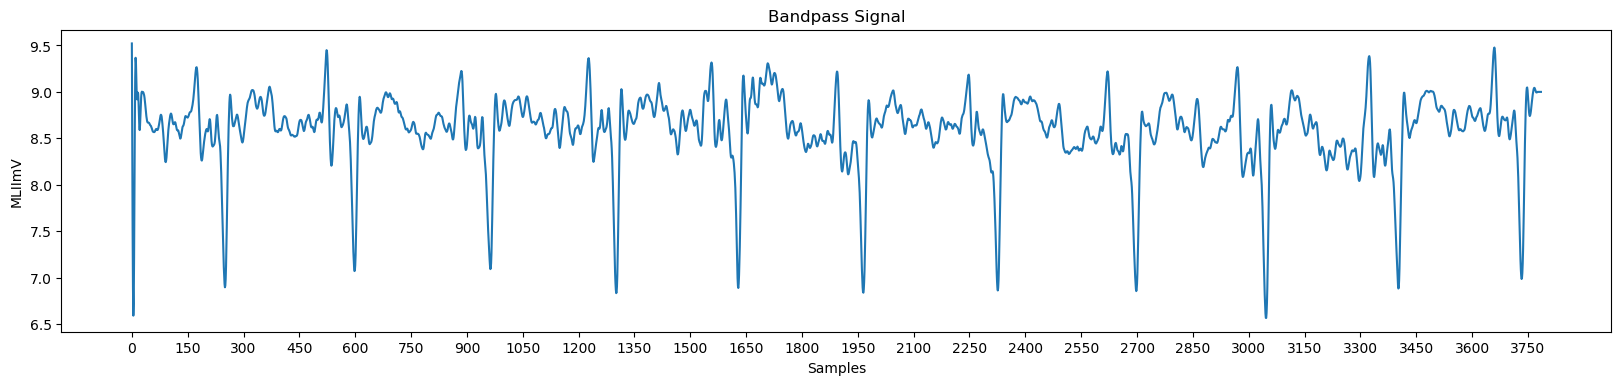

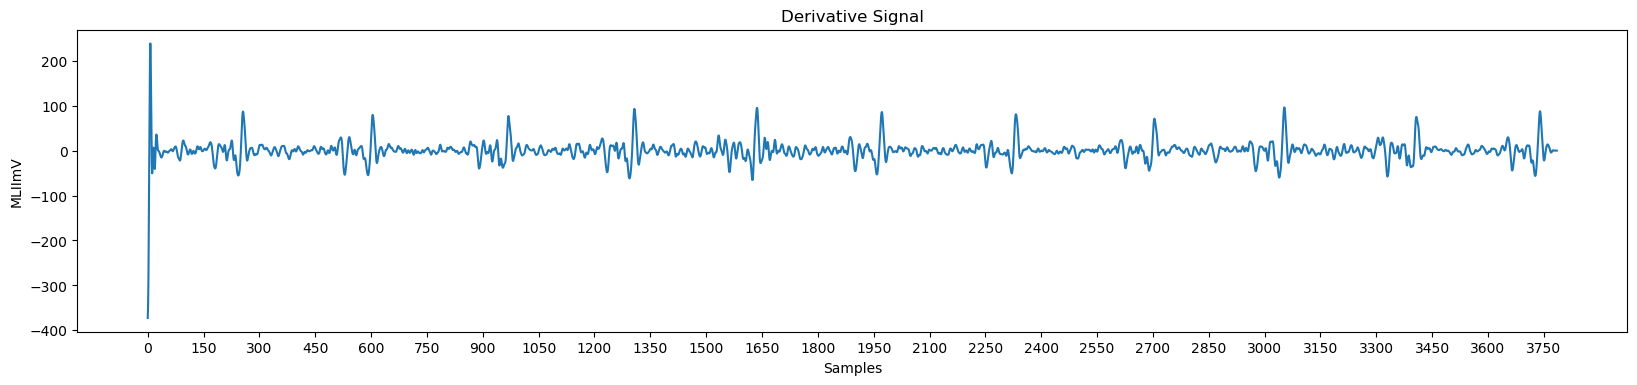

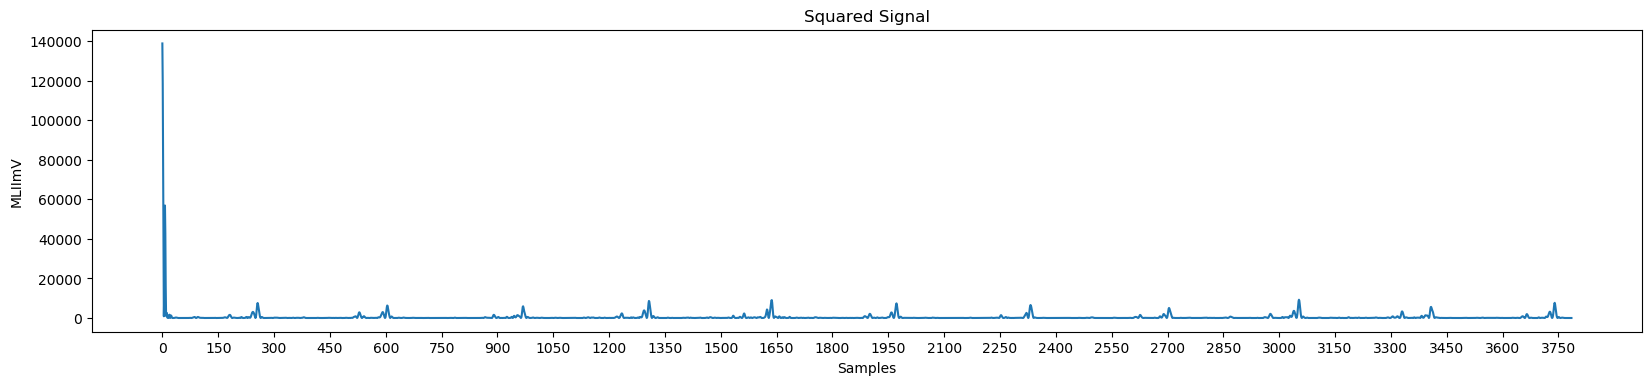

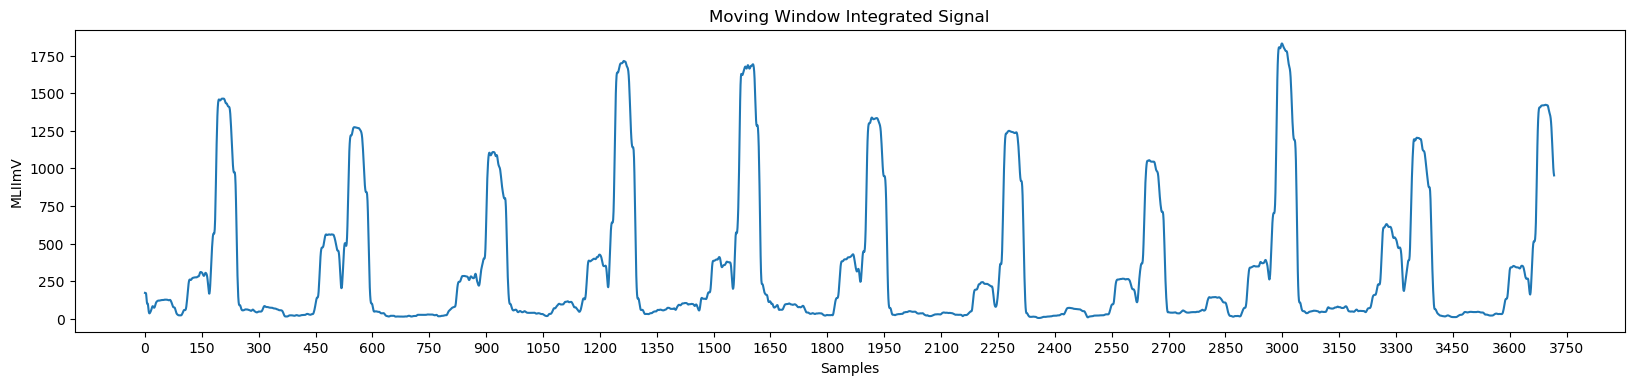

In [7]:
# Plotting bandpassed signal
plt.figure(figsize = (20,4), dpi = 100)
plt.xticks(np.arange(0, len(smoothed_signal)+1, 150))
plt.plot(smoothed_signal[32:len(smoothed_signal)-2])
plt.xlabel('Samples')
plt.ylabel('MLIImV')
plt.title("Bandpass Signal")

# Plotting derived signal
plt.figure(figsize = (20,4), dpi = 100)
plt.xticks(np.arange(0, len(der)+1, 150))
plt.plot(der[32:len(der)-2])
plt.xlabel('Samples')
plt.ylabel('MLIImV')
plt.title("Derivative Signal")

# Plotting squared signal
plt.figure(figsize = (20,4), dpi = 100)
plt.xticks(np.arange(0, len(sqr)+1, 150))
plt.plot(sqr[32:len(sqr)-2])
plt.xlabel('Samples')
plt.ylabel('MLIImV')
plt.title("Squared Signal")

# Plotting moving window integrated signal
plt.figure(figsize = (20,4), dpi = 100)
plt.xticks(np.arange(0, len(mwin)+1, 150))
plt.plot(mwin[100:len(mwin)-2])
plt.xlabel('Samples')
plt.ylabel('MLIImV')
plt.title("Moving Window Integrated Signal")

## Calculating Heart Rate

## Plotting R Peaks

In [8]:
# Importing Libraries
from scipy import signal as sg

class heart_rate():

  def __init__(self,signal,samp_freq):
    '''
    Initialize Variables
    :param signal: input signal
    :param samp_freq: sample frequency of input signal
    '''

    # Initialize variables
    self.RR1, self.RR2, self.probable_peaks, self.r_locs, self.peaks, self.result = ([] for i in range(6))
    self.SPKI, self.NPKI, self.Threshold_I1, self.Threshold_I2, self.SPKF, self.NPKF, self.Threshold_F1, self.Threshold_F2 = (0 for i in range(8))

    self.T_wave = False          
    self.m_win = mwin
    self.b_pass = smoothed_signal
    self.samp_freq = samp_freq
    self.signal = signal
    self.win_150ms = round(0.15*self.samp_freq)

    self.RR_Low_Limit = 0
    self.RR_High_Limit = 0
    self.RR_Missed_Limit = 0
    self.RR_Average1 = 0


  def approx_peak(self):
    '''
    Approximate peak locations
    '''   

    # FFT convolution
    slopes = sg.fftconvolve(self.m_win, np.full((25,), 1) / 25, mode='same')

    # Finding approximate peak locations
    for i in range(round(0.5*self.samp_freq) + 1,len(slopes)-1):
        if (slopes[i] > slopes[i-1]) and (slopes[i+1] < slopes[i]):
            self.peaks.append(i)  


  def adjust_rr_interval(self,ind):
    '''
    Adjust RR Interval and Limits
    :param ind: current index in peaks array
    '''

    # Finding the eight most recent RR intervals
    self.RR1 = np.diff(self.peaks[max(0,ind - 8) : ind + 1])/self.samp_freq   

    # Calculating RR Averages
    self.RR_Average1 = np.mean(self.RR1)
    RR_Average2 = self.RR_Average1
      
    # Finding the eight most recent RR intervals lying between RR Low Limit and RR High Limit  
    if (ind >= 8):
        for i in range(0, 8):
            if (self.RR_Low_Limit < self.RR1[i] < self.RR_High_Limit): 
                self.RR2.append(self.RR1[i])

                if (len(self.RR2) > 8):
                    self.RR2.remove(self.RR2[0])
                    RR_Average2 = np.mean(self.RR2)    

    # Adjusting the RR Low Limit and RR High Limit
    if (len(self.RR2) > 7 or ind < 8):
        self.RR_Low_Limit = 0.92 * RR_Average2        
        self.RR_High_Limit = 1.16 * RR_Average2
        self.RR_Missed_Limit = 1.66 * RR_Average2


  def searchback(self,peak_val,RRn,sb_win):
      '''
      Searchback
      :param peak_val: peak location in consideration
      :param RRn: the most recent RR interval
      :param sb_win: searchback window
      '''

      # Check if the most recent RR interval is greater than the RR Missed Limit
      if (RRn > self.RR_Missed_Limit):
          # Initialize a window to searchback  
          win_rr = self.m_win[peak_val - sb_win + 1 : peak_val + 1] 

          # Find the x locations inside the window having y values greater than Threshold I1             
          coord = np.asarray(win_rr > self.Threshold_I1).nonzero()[0]

          # Find the x location of the max peak value in the search window
          if (len(coord) > 0):
              for pos in coord:
                  if (win_rr[pos] == max(win_rr[coord])):
                      x_max = pos
                      break
          else:
            x_max = None
 
          # If the max peak value is found
          if (x_max is not None):   
            # Update the thresholds corresponding to moving window integration
            self.SPKI = 0.25 * self.m_win[x_max] + 0.75 * self.SPKI                         
            self.Threshold_I1 = self.NPKI + 0.25 * (self.SPKI - self.NPKI)
            self.Threshold_I2 = 0.5 * self.Threshold_I1         

            # Initialize a window to searchback 
            win_rr = self.b_pass[x_max - self.win_150ms: min(len(self.b_pass) -1, x_max)]  

            # Find the x locations inside the window having y values greater than Threshold F1                   
            coord = np.asarray(win_rr > self.Threshold_F1).nonzero()[0]

            # Find the x location of the max peak value in the search window
            if (len(coord) > 0):
              for pos in coord:
                  if (win_rr[pos] == max(win_rr[coord])):
                      r_max = pos
                      break
            else:
              r_max = None

            # If the max peak value is found
            if (r_max is not None):
              # Update the thresholds corresponding to bandpass filter
              if self.b_pass[r_max] > self.Threshold_F2:                                                        
                  self.SPKF = 0.25 * self.b_pass[r_max] + 0.75 * self.SPKF                            
                  self.Threshold_F1 = self.NPKF + 0.25 * (self.SPKF - self.NPKF)
                  self.Threshold_F2 = 0.5 * self.Threshold_F1      

                  # Append the probable R peak location                      
                  self.r_locs.append(r_max)                                                


  def find_t_wave(self,peak_val,RRn,ind,prev_ind):
    '''
    T Wave Identification
    :param peak_val: peak location in consideration
    :param RRn: the most recent RR interval
    :param ind: current index in peaks array
    :param prev_ind: previous index in peaks array
    '''

    if (self.m_win[peak_val] >= self.Threshold_I1): 
        if (ind > 0 and 0.20 < RRn < 0.36):
          # Find the slope of current and last waveform detected        
          curr_slope = max(np.diff(self.m_win[peak_val - round(self.win_150ms/2) : peak_val + 1]))
          last_slope = max(np.diff(self.m_win[self.peaks[prev_ind] - round(self.win_150ms/2) : self.peaks[prev_ind] + 1]))
          
          # If current waveform slope is less than half of last waveform slope
          if (curr_slope < 0.5*last_slope):  
              # T Wave is found and update noise threshold                      
              self.T_wave = True                             
              self.NPKI = 0.125 * self.m_win[peak_val] + 0.875 * self.NPKI 

        if (not self.T_wave):
            # T Wave is not found and update signal thresholds
            if (self.probable_peaks[ind] > self.Threshold_F1):   
                self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI                                         
                self.SPKF = 0.125 * self.b_pass[ind] + 0.875 * self.SPKF 

                # Append the probable R peak location
                self.r_locs.append(self.probable_peaks[ind])  

            else:
                self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI
                self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF                   

    # Update noise thresholds
    elif (self.m_win[peak_val] < self.Threshold_I1) or (self.Threshold_I1 < self.m_win[peak_val] < self.Threshold_I2):
        self.NPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.NPKI  
        self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF


  def adjust_thresholds(self,peak_val,ind):
    '''
    Adjust Noise and Signal Thresholds During Learning Phase
    :param peak_val: peak location in consideration
    :param ind: current index in peaks array
    '''

    if (self.m_win[peak_val] >= self.Threshold_I1): 
        # Update signal threshold
        self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI

        if (self.probable_peaks[ind] > self.Threshold_F1):                                            
            self.SPKF = 0.125 * self.b_pass[ind] + 0.875 * self.SPKF 

            # Append the probable R peak location
            self.r_locs.append(self.probable_peaks[ind])  

        else:
            # Update noise threshold
            self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF                                    
        
    # Update noise thresholds    
    elif (self.m_win[peak_val] < self.Threshold_I2) or (self.Threshold_I2 < self.m_win[peak_val] < self.Threshold_I1):
        self.NPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.NPKI  
        self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF


  def update_thresholds(self):
    '''
    Update Noise and Signal Thresholds for next iteration
    '''

    self.Threshold_I1 = self.NPKI + 0.25 * (self.SPKI - self.NPKI)
    self.Threshold_F1 = self.NPKF + 0.25 * (self.SPKF - self.NPKF)
    self.Threshold_I2 = 0.5 * self.Threshold_I1 
    self.Threshold_F2 = 0.5 * self.Threshold_F1
    self.T_wave = False 


  def ecg_searchback(self):
    '''
    Searchback in ECG signal to increase efficiency
    '''

    # Filter the unique R peak locations
    self.r_locs = np.unique(np.array(self.r_locs).astype(int))

    # Initialize a window to searchback
    win_200ms = round(0.2*self.samp_freq)
   
    for r_val in self.r_locs:
        coord = np.arange(r_val - win_200ms, min(len(self.signal), r_val + win_200ms + 1), 1)

        # Find the x location of the max peak value
        if (len(coord) > 0):
          for pos in coord:
              if (self.signal[pos] == max(self.signal[coord])):
                  x_max = pos
                  break
        else:
          x_max = None

        # Append the peak location
        if (x_max is not None):   
          self.result.append(x_max)


  def find_r_peaks(self):
    '''
    R Peak Detection
    '''

    # Find approximate peak locations
    self.approx_peak()

    # Iterate over possible peak locations
    for ind in range(len(self.peaks)):

        # Initialize the search window for peak detection
        peak_val = self.peaks[ind]
        win_300ms = np.arange(max(0, self.peaks[ind] - self.win_150ms), min(self.peaks[ind] + self.win_150ms, len(self.b_pass)-1), 1)
        max_val = max(self.b_pass[win_300ms], default = 0)

        # Find the x location of the max peak value
        if (max_val != 0):        
          x_coord = np.asarray(self.b_pass == max_val).nonzero()
          self.probable_peaks.append(x_coord[0][0])
        
        if (ind < len(self.probable_peaks) and ind != 0):
            # Adjust RR interval and limits
            self.adjust_rr_interval(ind)
            
            # Adjust thresholds in case of irregular beats
            if (self.RR_Average1 < self.RR_Low_Limit or self.RR_Average1 > self.RR_Missed_Limit): 
                self.Threshold_I1 /= 2
                self.Threshold_F1 /= 2

            RRn = self.RR1[-1]

            # Searchback
            self.searchback(peak_val,RRn,round(RRn*self.samp_freq))

            # T Wave Identification
            self.find_t_wave(peak_val,RRn,ind,ind-1)

        else:
          # Adjust threholds
          self.adjust_thresholds(peak_val,ind)

        # Update threholds for next iteration
        self.update_thresholds()

    # Searchback in ECG signal 
    self.ecg_searchback()

    return self.result

Heart Rate 143.37662337662337 BPM


Text(0.5, 1.0, 'R Peak Locations')

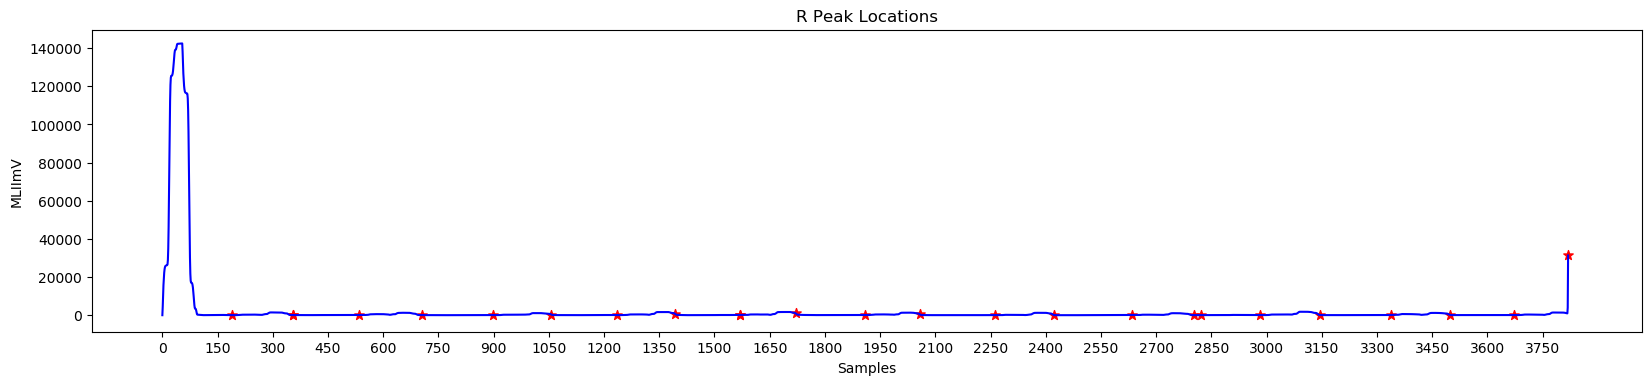

In [9]:
# Convert ecg signal to numpy array
signal = ecg.iloc[:,1].values
# Find the R peak locations
hr = heart_rate(signal, annotation.fs)
result = hr.find_r_peaks()
result = np.array(result)

# Clip the x locations less than 0 (Learning Phase)
result = result[result > 0]

# Calculate the heart rate
heartRate = (60*annotation.fs)/np.average(np.diff(result[1:]))
print("Heart Rate",heartRate, "BPM")

# Plotting the R peak locations in ECG signal
plt.figure(figsize = (20,4), dpi = 100)
plt.xticks(np.arange(0, len(output_signal)+1, 150))
plt.plot(output_signal, color = 'blue')        
plt.scatter(result, output_signal[result], color = 'red', s = 50, marker= '*')
plt.xlabel('Samples')
plt.ylabel('MLIImV')
plt.title("R Peak Locations")

#ToDo: Add Heart Condition Classification

In [10]:
import os
import shutil

cmd = 'python3'
locate = shutil.which(cmd)

print(locate)

# !pip install joblib
# !pip install scikit-learn

/usr/bin/python3


In [11]:
# import joblib
# import numpy as np
# import skl2onnx
# from skl2onnx import convert_sklearn
# from skl2onnx.common.data_types import FloatTensorType

# # Load the trained Random Forest model
# rf_model = joblib.load("arrhythmia_rf_model.pkl")

# # Define input shape (1D array with 1 feature)
# initial_type = [("input", FloatTensorType([None, 1]))]

# # Convert the model to ONNX format
# onnx_model = convert_sklearn(rf_model, initial_types=initial_type)

# # Save ONNX model to file
# with open("arrhythmia_rf_model.onnx", "wb") as f:
#     f.write(onnx_model.SerializeToString())

# print("Model converted and saved as 'arrhythmia_rf_model.onnx'")


In [12]:
# import onnxruntime as ort

# # Load the ONNX model
# ort_session = ort.InferenceSession("arrhythmia_rf_model.onnx")

# def predict_arrhythmia_onnx(heart_rate):
#     """
#     Predicts arrhythmia using the ONNX model.
    
#     Parameters:
#     - heart_rate (float): The heart rate in BPM.
    
#     Returns:
#     - str: "Normal", "Tachycardia", or "Bradycardia".
#     """
#     # Prepare input data (reshape to match model input)
#     input_data = np.array([[heart_rate]], dtype=np.float32)

#     # Run inference
#     output = ort_session.run(None, {"input": input_data})

#     # Extract predicted class (output is a list)
#     prediction = int(output[0][0])

#     # Map numeric predictions to labels
#     label_mapping = {0: "Normal", 1: "Tachycardia", 2: "Bradycardia"}
#     return label_mapping.get(prediction, "Unknown")

# # Example usage
# heart_rate = 80  # Example heart rate
# prediction = predict_arrhythmia_onnx(heart_rate)
# print(f"Prediction for heart rate {heart_rate}: {prediction}")


In [13]:
# import sys
# # print(sys.executable)

# # import sklearn.externals as extjoblib
# import joblib
# # import loky
# # from loky import get_reusable_executor
# # print(joblib.__version__)
# # sys.modules['sklearn.externals.joblib'] = joblib

# # from sklearn.ensemble import RandomForestClassifier
# # from sklearn.preprocessing import LabelEncoder

# # Load the trained model and label encoder
# rf_model = joblib.load('arrhythmia_rf_model.pkl')
# label_encoder = joblib.load('label_encoder.pkl')

# def predict_arrhythmia(heart_rate):
#     """
#     Predicts whether a given heart rate indicates arrhythmia or not.

#     Parameters:
#     - heart_rate (float): The average heart rate in beats per minute.

#     Returns:
#     - str: "Normal" if no arrhythmia, "Arrhythmia" if arrhythmia is detected.
#     """
#     # Reshape the heart rate value to match the input shape for the model
#     input_data = np.array([[heart_rate]])

#     # Make a prediction using the trained model
#     prediction = rf_model.predict(input_data)

#     # Decode the predicted label
#     predicted_label = label_encoder.inverse_transform(prediction)[0]

#     # Determine the result based on the predicted label
#     if predicted_label == 'T':
#         return "Tachycardia"
#     elif predicted_label == "B":
#         return "Bradycardia"
#     else:
#         return "Normal"

# # Convert ecg signal to numpy array
# signal = ecg.iloc[:,1].values

# # Find the R peak locations
# hr = heart_rate(signal,annotation.fs)
# result = hr.find_r_peaks()
# result = np.array(result)

# # Clip the x locations less than 0 (Learning Phase)
# result = result[result > 0]

# # Calculate the heart rate
# heartRate = (60*annotation.fs)/np.average(np.diff(result[1:]))
# print("Heart Rate",heartRate, "BPM")
# prediction = predict_arrhythmia(heartRate)
# print(f"Prediction for heart rate {heartRate}: {prediction}")

# # Plotting the R peak locations in ECG signal
# plt.figure(figsize = (20,4), dpi = 100)
# plt.xticks(np.arange(0, len(signal)+1, 150))
# plt.plot(signal, color = 'blue')
# plt.scatter(result, signal[result], color = 'red', s = 50, marker= '*')
# plt.xlabel('Samples')
# plt.ylabel('MLIImV')
# plt.title("R Peak Locations")

## Random Forest Machine Learning

In [14]:
import numpy as np
import random
from collections import Counter
import matplotlib.pyplot as plt

# Generate synthetic dataset manually
np.random.seed(42)
num_samples = 500
num_features = 5

class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y):
        self.tree = self._grow_tree(X, y, depth=0)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree) for x in X])

    def _gini_impurity(self, y):
        m = len(y)
        if m == 0:
            return 0
        counts = np.bincount(y)
        probs = counts / m
        return 1 - np.sum(probs ** 2)

    def _best_split(self, X, y):
        best_feature, best_threshold, best_impurity, best_left, best_right = None, None, float('inf'), None, None
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_mask = X[:, feature] < threshold
                right_mask = ~left_mask
                if np.sum(left_mask) < self.min_samples_split or np.sum(right_mask) < self.min_samples_split:
                    continue
                impurity = (self._gini_impurity(y[left_mask]) * np.sum(left_mask) +
                            self._gini_impurity(y[right_mask]) * np.sum(right_mask)) / len(y)
                if impurity < best_impurity:
                    best_feature, best_threshold, best_impurity, best_left, best_right = feature, threshold, impurity, left_mask, right_mask
        return best_feature, best_threshold, best_left, best_right

    def _grow_tree(self, X, y, depth):
        if len(set(y)) == 1 or depth == self.max_depth or len(y) < self.min_samples_split:
            return Counter(y).most_common(1)[0][0]
        feature, threshold, left_mask, right_mask = self._best_split(X, y)
        if feature is None:
            return Counter(y).most_common(1)[0][0]
        return {
            'feature': feature,
            'threshold': threshold,
            'left': self._grow_tree(X[left_mask], y[left_mask], depth + 1),
            'right': self._grow_tree(X[right_mask], y[right_mask], depth + 1)
        }

    def _traverse_tree(self, x, node):
        if isinstance(node, dict):
            if x[node['feature']] < node['threshold']:
                return self._traverse_tree(x, node['left'])
            else:
                return self._traverse_tree(x, node['right'])
        return node

class RandomForestClassifier:
    def __init__(self, n_trees=10, max_depth=None, min_samples_split=2, max_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            indices = np.random.choice(len(y), len(y), replace=True)
            X_sample, y_sample = X[indices], y[indices]
            tree = DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        majority_votes = [Counter(tree_preds[:, i]).most_common(1)[0][0] for i in range(X.shape[0])]
        return np.array(majority_votes)

In [15]:
# Generating synthetic heart rate values
normal_heart_rate = np.random.uniform(60, 100, 150)  # Normal heart rate range
tachycardia_heart_rate = np.random.uniform(100, 180, 100)  # Tachycardia range
bradycardia_heart_rate = np.random.uniform(30, 60, 100)  # Bradycardia range

# Combining data
X = np.concatenate([normal_heart_rate, tachycardia_heart_rate, bradycardia_heart_rate]).reshape(-1, 1)
y = np.array([0] * 150 + [1] * 100 + [2] * 100)  # 0: Normal, 1: Tachycardia, 2: Bradycardia

# Splitting into training and testing
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Train and test the model
rf_model = RandomForestClassifier(n_trees=10, max_depth=5, min_samples_split=5)
rf_model.fit(X_train, y_train)
print("complete")

complete


## Predicting Heart Condition

In [16]:
# Function to Predict Arrhythmia Type
def predict_arrhythmia(heart_rate):
    """
    Predicts heart condition based on heart rate.

    Parameters:
    - heart_rate (float): The average heart rate in BPM.

    Returns:
    - str: "Normal", "Tachycardia", or "Bradycardia".
    """
    input_data = np.array([[heart_rate]])
    prediction = rf_model.predict(input_data)[0]
    
    # Mapping labels
    condition_mapping = {0: "Normal", 1: "Tachycardia", 2: "Bradycardia"}
    return condition_mapping[prediction]

# ECG Processing Simulation (Using Dummy ECG Data)
# Replace this with real ECG signal processing
ecg_signal = np.sin(np.linspace(0, 50, 1000))  # Simulated ECG waveform
fs = 250  # Sampling frequency in Hz
# r_peaks = np.where((ecg_signal[:-1] < 0) & (ecg_signal[1:] > 0))[0]  # Detecting zero crossings

# Computing heart rate from R-peaks
heartRate = (60 * fs) / np.average(np.diff(result[1:]))
print(f"Heart Rate: {heartRate} BPM")

# Predict heart condition
prediction = predict_arrhythmia(heartRate)
print(f"Prediction for heart rate: {prediction}")

# Plot ECG signal with detected R-peaks
# plt.figure(figsize=(12, 4))
# plt.plot(ecg_signal, label="ECG Signal", color="blue")
# plt.scatter(result, ecg_signal[result], color="red", label="R Peaks", s=50)
# plt.xlabel("Samples")
# plt.ylabel("ECG Amplitude")
# plt.title("ECG Signal with Detected R-Peaks")
# plt.legend()
# plt.show()

Heart Rate: 99.56709956709958 BPM
Prediction for heart rate: Normal
